In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-11 16:34:42.227684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 16:34:47.234741: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-11 16:34:55.770329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-11 16:34:55.770627: W tensorflow/strea

2.10.1


In [2]:
# !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "Sign-Language-Digits-Dataset/Dataset"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 1438 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 320 images belonging to 10 classes.


In [8]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-11 16:35:10.320707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-11 16:35:10.342815: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-11 16:35:10.342926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3a4503591aa6): /proc/driver/nvidia/version does not exist
2023-09-11 16:35:10.362795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

574710816/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [9]:
##DEFINIMOS EL MODELO
num_classes = 10
epochs = 100

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

80134624/80134624 [==============================] - 0s 0us/step
22


In [10]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-06', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 9.1756 - accuracy: 0.1050
Epoch 1: accuracy improved from -inf to 0.10501, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 102s 2s/step - loss: 9.1756 - accuracy: 0.1050 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 9.0697 - accuracy: 0.1592
Epoch 2: accuracy improved from 0.10501 to 0.15925, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 98s 2s/step - loss: 9.0697 - accuracy: 0.1592 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 8.9702 - accuracy: 0.2232
Epoch 3: accuracy improved from 0.15925 to 0.22323, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 99s 2s/step - loss: 8.9702 - accuracy: 0.2232 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 8.7866 - accuracy: 0.3053
Epoch 4: accuracy improved from 0.22323 to 0.30529, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 96s 2s/step - loss: 8.7866 - accuracy: 0.3053 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - ETA: 0s - loss: 8.5206 - accuracy: 0.3783
Epoch 5: accuracy improved from 0.30529 to 0.37830, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 99s 2s/step - loss: 8.5206 - accuracy: 0.3783 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - ETA: 0s - loss: 8.2600 - accuracy: 0.4604
Epoch 6: accuracy improved from 0.37830 to 0.46036, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 102s 2s/step - loss: 8.2600 - accuracy: 0.4604 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - ETA: 0s - loss: 8.0838 - accuracy: 0.5202
Epoch 7: accuracy improved from 0.46036 to 0.52017, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 98s 2s/step - loss: 8.0838 - accuracy: 0.5202 - lr: 0.0010
Epoch 8/100
45/45 [==============================] - ETA: 0s - loss: 7.8787 - accuracy: 0.6022
Epoch 8: accuracy improved from 0.52017 to 0.60223, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 97s 2s/step - loss: 7.8787 - accuracy: 0.6022 - lr: 0.0010
Epoch 9/100
45/45 [==============================] - ETA: 0s - loss: 7.7232 - accuracy: 0.6356
Epoch 9: accuracy improved from 0.60223 to 0.63560, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 97s 2s/step - loss: 7.7232 - accuracy: 0.6356 - lr: 0.0010
Epoch 10/100
45/45 [==============================] - ETA: 0s - loss: 7.5724 - accuracy: 0.6898
Epoch 10: accuracy improved from 0.63560 to 0.68985, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 96s 2s/step - loss: 7.5724 - accuracy: 0.6898 - lr: 0.0010
Epoch 11/100
45/45 [==============================] - ETA: 0s - loss: 7.3983 - accuracy: 0.7559
Epoch 11: accuracy improved from 0.68985 to 0.75591, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 98s 2s/step - loss: 7.3983 - accuracy: 0.7559 - lr: 0.0010
Epoch 12/100
45/45 [==============================] - ETA: 0s - loss: 7.2734 - accuracy: 0.8046
Epoch 12: accuracy improved from 0.75591 to 0.80459, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 97s 2s/step - loss: 7.2734 - accuracy: 0.8046 - lr: 0.0010
Epoch 13/100
45/45 [==============================] - ETA: 0s - loss: 7.2658 - accuracy: 0.7955
Epoch 13: accuracy did not improve from 0.80459
45/45 [==============================] - 93s 2s/step - loss: 7.2658 - accuracy: 0.7955 - lr: 0.0010
Epoch 14/100
45/45 [==============================] - ETA: 0s - loss: 7.1579 - accuracy: 0.8261
Epoch 14: accuracy improved from 0.80459 to 0.82615, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 98s 2s/step - loss: 7.1579 - accuracy: 0.8261 - lr: 0.0010
Epoch 15/100
45/45 [==============================] - ETA: 0s - loss: 7.0845 - accuracy: 0.8338
Epoch 15: accuracy improved from 0.82615 to 0.83380, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 98s 2s/step - loss: 7.0845 - accuracy: 0.8338 - lr: 0.0010
Epoch 16/100
45/45 [==============================] - ETA: 0s - loss: 7.0420 - accuracy: 0.8651
Epoch 16: accuracy improved from 0.83380 to 0.86509, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 98s 2s/step - loss: 7.0420 - accuracy: 0.8651 - lr: 0.0010
Epoch 17/100
45/45 [==============================] - ETA: 0s - loss: 6.9952 - accuracy: 0.8748
Epoch 17: accuracy improved from 0.86509 to 0.87483, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 97s 2s/step - loss: 6.9952 - accuracy: 0.8748 - lr: 0.0010
Epoch 18/100
45/45 [==============================] - ETA: 0s - loss: 6.9214 - accuracy: 0.8950
Epoch 18: accuracy improved from 0.87483 to 0.89499, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 96s 2s/step - loss: 6.9214 - accuracy: 0.8950 - lr: 0.0010
Epoch 19/100
45/45 [==============================] - ETA: 0s - loss: 6.9234 - accuracy: 0.8887
Epoch 19: accuracy did not improve from 0.89499
45/45 [==============================] - 95s 2s/step - loss: 6.9234 - accuracy: 0.8887 - lr: 0.0010
Epoch 20/100
45/45 [==============================] - ETA: 0s - loss: 6.8870 - accuracy: 0.8985
Epoch 20: accuracy improved from 0.89499 to 0.89847, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 99s 2s/step - loss: 6.8870 - accuracy: 0.8985 - lr: 0.0010
Epoch 21/100
45/45 [==============================] - ETA: 0s - loss: 6.8382 - accuracy: 0.9138
Epoch 21: accuracy improved from 0.89847 to 0.91377, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 101s 2s/step - loss: 6.8382 - accuracy: 0.9138 - lr: 0.0010
Epoch 22/100
45/45 [==============================] - ETA: 0s - loss: 6.8707 - accuracy: 0.8971
Epoch 22: accuracy did not improve from 0.91377
45/45 [==============================] - 97s 2s/step - loss: 6.8707 - accuracy: 0.8971 - lr: 0.0010
Epoch 23/100
45/45 [==============================] - ETA: 0s - loss: 6.8121 - accuracy: 0.9200
Epoch 23: accuracy improved from 0.91377 to 0.92003, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 100s 2s/step - loss: 6.8121 - accuracy: 0.9200 - lr: 0.0010
Epoch 24/100
45/45 [==============================] - ETA: 0s - loss: 6.7803 - accuracy: 0.9228
Epoch 24: accuracy improved from 0.92003 to 0.92281, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 101s 2s/step - loss: 6.7803 - accuracy: 0.9228 - lr: 0.0010
Epoch 25/100
45/45 [==============================] - ETA: 0s - loss: 6.7630 - accuracy: 0.9332
Epoch 25: accuracy improved from 0.92281 to 0.93324, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 100s 2s/step - loss: 6.7630 - accuracy: 0.9332 - lr: 0.0010
Epoch 26/100
45/45 [==============================] - ETA: 0s - loss: 6.7445 - accuracy: 0.9332
Epoch 26: accuracy did not improve from 0.93324
45/45 [==============================] - 96s 2s/step - loss: 6.7445 - accuracy: 0.9332 - lr: 0.0010
Epoch 27/100
45/45 [==============================] - ETA: 0s - loss: 6.7011 - accuracy: 0.9381
Epoch 27: accuracy improved from 0.93324 to 0.93811, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 100s 2s/step - loss: 6.7011 - accuracy: 0.9381 - lr: 0.0010
Epoch 28/100
45/45 [==============================] - ETA: 0s - loss: 6.6821 - accuracy: 0.9402
Epoch 28: accuracy improved from 0.93811 to 0.94019, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 101s 2s/step - loss: 6.6821 - accuracy: 0.9402 - lr: 0.0010
Epoch 29/100
45/45 [==============================] - ETA: 0s - loss: 6.6593 - accuracy: 0.9506
Epoch 29: accuracy improved from 0.94019 to 0.95063, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 99s 2s/step - loss: 6.6593 - accuracy: 0.9506 - lr: 0.0010
Epoch 30/100
45/45 [==============================] - ETA: 0s - loss: 6.6458 - accuracy: 0.9471
Epoch 30: accuracy did not improve from 0.95063
45/45 [==============================] - 96s 2s/step - loss: 6.6458 - accuracy: 0.9471 - lr: 0.0010
Epoch 31/100
45/45 [==============================] - ETA: 0s - loss: 6.6352 - accuracy: 0.9444
Epoch 31: accuracy did not improve from 0.95063
45/45 [==============================] - 95s 2s/step - loss: 6.6352 - accuracy: 0.9444 - lr: 0.0010
Epoch 32/100
45/45 [==============================] - ETA: 0s - loss: 6.6196 - accuracy: 0.9437
Epoch 32: accuracy did not improve from 0.95063
45/45 [==============================] - 97s 2s/step - loss: 6.6196 - accuracy: 0.9437 - lr: 0.0010
Epoch 33/100
45/45 [==============================] - ETA: 0s - loss: 6.5898 - accuracy: 0.9527
Epoch 33: accuracy improved from 0.95063 to 0.95271, saving model to mod

INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 101s 2s/step - loss: 6.5898 - accuracy: 0.9527 - lr: 0.0010
Epoch 34/100
45/45 [==============================] - ETA: 0s - loss: 6.5558 - accuracy: 0.9611
Epoch 34: accuracy improved from 0.95271 to 0.96106, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 99s 2s/step - loss: 6.5558 - accuracy: 0.9611 - lr: 0.0010
Epoch 35/100
45/45 [==============================] - ETA: 0s - loss: 6.5487 - accuracy: 0.9569
Epoch 35: accuracy did not improve from 0.96106
45/45 [==============================] - 98s 2s/step - loss: 6.5487 - accuracy: 0.9569 - lr: 0.0010
Epoch 36/100
45/45 [==============================] - ETA: 0s - loss: 6.5433 - accuracy: 0.9562
Epoch 36: accuracy did not improve from 0.96106
45/45 [==============================] - 97s 2s/step - loss: 6.5433 - accuracy: 0.9562 - lr: 0.0010
Epoch 37/100
45/45 [==============================] - ETA: 0s - loss: 6.5420 - accuracy: 0.9597
Epoch 37: accuracy did not improve from 0.96106
45/45 [==============================] - 96s 2s/step - loss: 6.5420 - accuracy: 0.9597 - lr: 0.0010
Epoch 38/100
45/45 [==============================] - ETA: 0s - loss: 6.5152 - accuracy: 0.9576
Epoch 38: accuracy did not improve from 0.96106
45/45 [=================

INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 100s 2s/step - loss: 6.4749 - accuracy: 0.9645 - lr: 0.0010
Epoch 41/100
45/45 [==============================] - ETA: 0s - loss: 6.4794 - accuracy: 0.9576
Epoch 41: accuracy did not improve from 0.96453
45/45 [==============================] - 98s 2s/step - loss: 6.4794 - accuracy: 0.9576 - lr: 0.0010
Epoch 42/100
45/45 [==============================] - ETA: 0s - loss: 6.4415 - accuracy: 0.9687
Epoch 42: accuracy improved from 0.96453 to 0.96871, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 99s 2s/step - loss: 6.4415 - accuracy: 0.9687 - lr: 0.0010
Epoch 43/100
45/45 [==============================] - ETA: 0s - loss: 6.4497 - accuracy: 0.9624
Epoch 43: accuracy did not improve from 0.96871
45/45 [==============================] - 97s 2s/step - loss: 6.4497 - accuracy: 0.9624 - lr: 0.0010
Epoch 44/100
45/45 [==============================] - ETA: 0s - loss: 6.4065 - accuracy: 0.9694
Epoch 44: accuracy improved from 0.96871 to 0.96940, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 102s 2s/step - loss: 6.4065 - accuracy: 0.9694 - lr: 0.0010
Epoch 45/100
45/45 [==============================] - ETA: 0s - loss: 6.4188 - accuracy: 0.9680
Epoch 45: accuracy did not improve from 0.96940
45/45 [==============================] - 95s 2s/step - loss: 6.4188 - accuracy: 0.9680 - lr: 0.0010
Epoch 46/100
45/45 [==============================] - ETA: 0s - loss: 6.3958 - accuracy: 0.9673
Epoch 46: accuracy did not improve from 0.96940
45/45 [==============================] - 96s 2s/step - loss: 6.3958 - accuracy: 0.9673 - lr: 0.0010
Epoch 47/100
45/45 [==============================] - ETA: 0s - loss: 6.3974 - accuracy: 0.9652
Epoch 47: accuracy did not improve from 0.96940
45/45 [==============================] - 96s 2s/step - loss: 6.3974 - accuracy: 0.9652 - lr: 0.0010
Epoch 48/100
45/45 [==============================] - ETA: 0s - loss: 6.3678 - accuracy: 0.9708
Epoch 48: accuracy improved from 0.96940 to 0.97079, saving model to mo

INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 100s 2s/step - loss: 6.3678 - accuracy: 0.9708 - lr: 0.0010
Epoch 49/100
45/45 [==============================] - ETA: 0s - loss: 6.3490 - accuracy: 0.9750
Epoch 49: accuracy improved from 0.97079 to 0.97497, saving model to model-06


INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 101s 2s/step - loss: 6.3490 - accuracy: 0.9750 - lr: 0.0010
Epoch 50/100
45/45 [==============================] - ETA: 0s - loss: 6.3651 - accuracy: 0.9631
Epoch 50: accuracy did not improve from 0.97497
45/45 [==============================] - 97s 2s/step - loss: 6.3651 - accuracy: 0.9631 - lr: 0.0010
Epoch 51/100
45/45 [==============================] - ETA: 0s - loss: 6.3283 - accuracy: 0.9708
Epoch 51: accuracy did not improve from 0.97497
45/45 [==============================] - 98s 2s/step - loss: 6.3283 - accuracy: 0.9708 - lr: 0.0010
Epoch 52/100
45/45 [==============================] - ETA: 0s - loss: 6.3234 - accuracy: 0.9694
Epoch 52: accuracy did not improve from 0.97497
45/45 [==============================] - 97s 2s/step - loss: 6.3234 - accuracy: 0.9694 - lr: 0.0010
Epoch 53/100
45/45 [==============================] - ETA: 0s - loss: 6.3068 - accuracy: 0.9694
Epoch 53: accuracy did not improve from 0.97497
45/45 [================

INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 100s 2s/step - loss: 6.2454 - accuracy: 0.9805 - lr: 0.0010
Epoch 58/100
45/45 [==============================] - ETA: 0s - loss: 6.2656 - accuracy: 0.9618
Epoch 58: accuracy did not improve from 0.98053
45/45 [==============================] - 96s 2s/step - loss: 6.2656 - accuracy: 0.9618 - lr: 0.0010
Epoch 59/100
45/45 [==============================] - ETA: 0s - loss: 6.2361 - accuracy: 0.9715
Epoch 59: accuracy did not improve from 0.98053
45/45 [==============================] - 97s 2s/step - loss: 6.2361 - accuracy: 0.9715 - lr: 0.0010
Epoch 60/100
45/45 [==============================] - ETA: 0s - loss: 6.2179 - accuracy: 0.9771
Epoch 60: accuracy did not improve from 0.98053
45/45 [==============================] - 96s 2s/step - loss: 6.2179 - accuracy: 0.9771 - lr: 0.0010
Epoch 61/100
45/45 [==============================] - ETA: 0s - loss: 6.1855 - accuracy: 0.9854
Epoch 61: accuracy improved from 0.98053 to 0.98540, saving model to mo

INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 101s 2s/step - loss: 6.1855 - accuracy: 0.9854 - lr: 0.0010
Epoch 62/100
45/45 [==============================] - ETA: 0s - loss: 6.1872 - accuracy: 0.9784
Epoch 62: accuracy did not improve from 0.98540
45/45 [==============================] - 97s 2s/step - loss: 6.1872 - accuracy: 0.9784 - lr: 0.0010
Epoch 63/100
45/45 [==============================] - ETA: 0s - loss: 6.1943 - accuracy: 0.9701
Epoch 63: accuracy did not improve from 0.98540
45/45 [==============================] - 97s 2s/step - loss: 6.1943 - accuracy: 0.9701 - lr: 0.0010
Epoch 64/100
45/45 [==============================] - ETA: 0s - loss: 6.1738 - accuracy: 0.9743
Epoch 64: accuracy did not improve from 0.98540
45/45 [==============================] - 98s 2s/step - loss: 6.1738 - accuracy: 0.9743 - lr: 0.0010
Epoch 65/100
45/45 [==============================] - ETA: 0s - loss: 6.1471 - accuracy: 0.9764
Epoch 65: accuracy did not improve from 0.98540
45/45 [================

INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 105s 2s/step - loss: 6.0399 - accuracy: 0.9868 - lr: 0.0010
Epoch 75/100
45/45 [==============================] - ETA: 0s - loss: 6.0390 - accuracy: 0.9812
Epoch 75: accuracy did not improve from 0.98679
45/45 [==============================] - 96s 2s/step - loss: 6.0390 - accuracy: 0.9812 - lr: 0.0010
Epoch 76/100
45/45 [==============================] - ETA: 0s - loss: 6.0427 - accuracy: 0.9729
Epoch 76: accuracy did not improve from 0.98679
45/45 [==============================] - 102s 2s/step - loss: 6.0427 - accuracy: 0.9729 - lr: 0.0010
Epoch 77/100
45/45 [==============================] - ETA: 0s - loss: 6.0083 - accuracy: 0.9819
Epoch 77: accuracy did not improve from 0.98679
45/45 [==============================] - 95s 2s/step - loss: 6.0083 - accuracy: 0.9819 - lr: 0.0010
Epoch 78/100
45/45 [==============================] - ETA: 0s - loss: 5.9999 - accuracy: 0.9868
Epoch 78: accuracy did not improve from 0.98679
45/45 [===============

INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 100s 2s/step - loss: 5.9774 - accuracy: 0.9875 - lr: 0.0010
Epoch 80/100
45/45 [==============================] - ETA: 0s - loss: 5.9886 - accuracy: 0.9764
Epoch 80: accuracy did not improve from 0.98748
45/45 [==============================] - 96s 2s/step - loss: 5.9886 - accuracy: 0.9764 - lr: 0.0010
Epoch 81/100
45/45 [==============================] - ETA: 0s - loss: 5.9653 - accuracy: 0.9812
Epoch 81: accuracy did not improve from 0.98748
45/45 [==============================] - 96s 2s/step - loss: 5.9653 - accuracy: 0.9812 - lr: 0.0010
Epoch 82/100
45/45 [==============================] - ETA: 0s - loss: 5.9727 - accuracy: 0.9757
Epoch 82: accuracy did not improve from 0.98748
45/45 [==============================] - 98s 2s/step - loss: 5.9727 - accuracy: 0.9757 - lr: 0.0010
Epoch 83/100
45/45 [==============================] - ETA: 0s - loss: 5.9505 - accuracy: 0.9854
Epoch 83: accuracy did not improve from 0.98748
45/45 [================

INFO:tensorflow:Assets written to: model-06/assets


INFO:tensorflow:Assets written to: model-06/assets


45/45 [==============================] - 101s 2s/step - loss: 5.7744 - accuracy: 0.9889 - lr: 0.0010
Epoch 99/100
45/45 [==============================] - ETA: 0s - loss: 5.7674 - accuracy: 0.9847
Epoch 99: accuracy did not improve from 0.98887
45/45 [==============================] - 96s 2s/step - loss: 5.7674 - accuracy: 0.9847 - lr: 0.0010
Epoch 100/100
45/45 [==============================] - ETA: 0s - loss: 5.7547 - accuracy: 0.9847
Epoch 100: accuracy did not improve from 0.98887
45/45 [==============================] - 97s 2s/step - loss: 5.7547 - accuracy: 0.9847 - lr: 0.0010


In [11]:
preds_test = model.predict(test_generator)

10/10 [==============================] - 6s 603ms/step


In [12]:
evaluate_test = model.evaluate(test_generator)

10/10 [==============================] - 7s 658ms/step - loss: 5.8000 - accuracy: 0.9688


In [13]:
evaluate_test

[5.7999773025512695, 0.96875]

In [14]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 7, 1, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [15]:
y_real_test = test_generator.classes
y_real_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [16]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.975

In [27]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[32,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 32,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2, 30,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 32,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 29,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 31,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0, 31]])

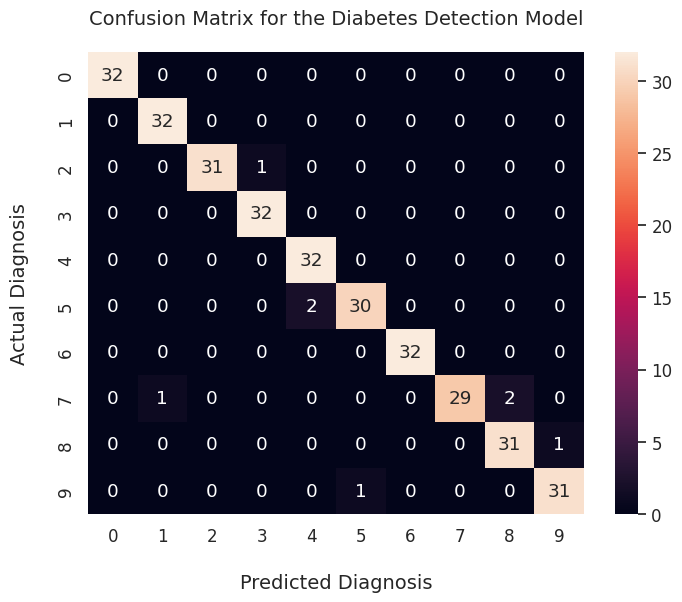

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [29]:
preds_val = model.predict(valid_generator)

10/10 [==============================] - 7s 732ms/step


In [30]:
evaluate_val = model.evaluate(valid_generator)

10/10 [==============================] - 6s 566ms/step - loss: 5.8118 - accuracy: 0.9836


In [33]:
evaluate_val

[5.811805248260498, 0.9835526347160339]

In [34]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [35]:
y_real_val = valid_generator.classes
y_real_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [36]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9835526315789473

In [37]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 29,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 30,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 30,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 30,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 29,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 31,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 30]])

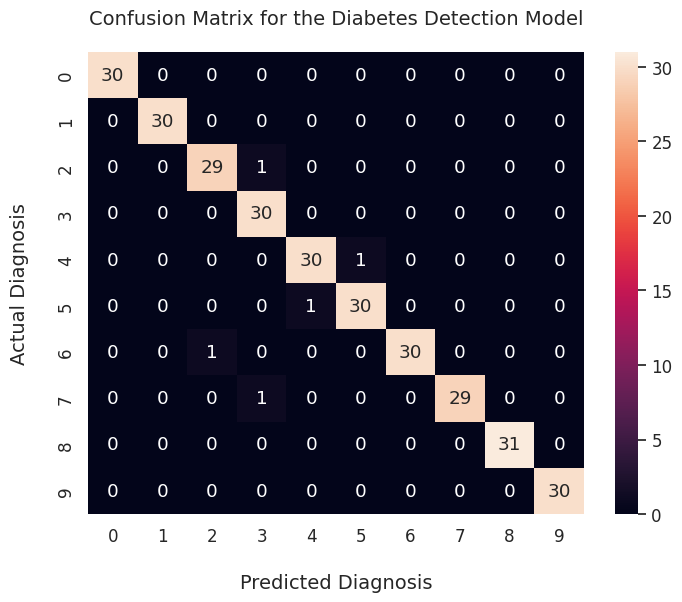

In [38]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()